In [7]:
import numpy as np
import scipy as sp
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

import deleon_berne as db

from tqdm import tqdm
from tqdm.auto import trange
import caffeine

import matplotlib.pylab as plt
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib as mpl
from pylab import rcParams
import mpl_toolkits.mplot3d.axes3d as p3


In [8]:
plt.style.use('seaborn')

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
plt.style.use('seaborn-white')

tick_labelsize = 10
axes_labelsize = 25
mpl.rcParams['xtick.labelsize'] = tick_labelsize
mpl.rcParams['ytick.labelsize'] = tick_labelsize
mpl.rcParams['axes.labelsize'] = axes_labelsize
mpl.rcParams['font.size'] = 20

output_filename = 'DS_and_gap_times/'

### Dividing surfaces

In [ ]:
#             m_x, m_y, lamb, zeta, V,  y_w,     e_s, D_x
parameters = [8,   8,   1.5,  1.0,  1,  1/2**.5, 1,   10]
energy_level = 2
N = 20

x_PO, t_period_PO = db.UPO(parameters, energy_level, 100)
times = np.linspace(0, t_period_PO, 100)

points = db.forward_DS(N, parameters, energy_level, 20)
N_points = np.size(points, 0)


fig = plt.figure(figsize = (16,8))
axis_fs = 20

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_PO(times)[0,:], x_PO(times)[2,:])
ax1.set_xlabel('$x$',fontsize=axis_fs)
ax1.set_ylabel('$p_x$',fontsize=axis_fs)
ax1.set_title('UPO for De Leon Berne System',fontsize=axis_fs)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(points[:,0], points[:,2], points[:,3], c='g', label = 'Forward DS')
ax2.scatter(points[:,0], points[:,2], -points[:,3], c='r', label = 'Backward DS')
ax2.plot(x_PO(times)[0,:], x_PO(times)[2,:], c='k', linewidth=4, label = 'UPO (NHIM)')
ax2.legend(fontsize=13)

ax2.set_title('Dividing Surface for De Leon Berne System', fontsize=axis_fs, pad = 42)
ax2.set_xlabel('$x$', fontsize=axis_fs)
ax2.set_ylabel('$p_x$', fontsize=axis_fs)
ax2.set_zlabel('$p_y$', fontsize=axis_fs)

print("number of points per hemisphere: ",N_points)

# fig.savefig(output_filename+'UPO_DS_DB')

### Heatmaps of gap times for initial position on forward DS

In [4]:
energy_level = 1.02

# lambdas = [0.1, 0.8, 2.5]
# zetas = [0.1, 1.2, 3.0]

lambdas = [2.5]
zetas = [3.0]

N = 150
max_runtime = 500
UPO_timespan = 100

#----------------------------------------------------------------------------

for lambda_num in range(len(lambdas)):
    for zeta_num in range(len(zetas)):
        lamb = lambdas[lambda_num]
        zeta = zetas[zeta_num]
        
        fig_number = lambda_num*len(zetas)+zeta_num + 1
        pbar_desc = 'section {} out of {}'.format(fig_number, len(lambdas)*len(zetas))

        #             m_x, m_y, lamb, zeta, V,  y_w,     e_s, D_x
        parameters = [8,   8,   lamb,  zeta,  1,  1/2**.5, 1,   10]

        points = db.forward_DS(N, parameters, energy_level, UPO_timespan)
        N_points = np.size(points, 0)

        points_gap_times = np.zeros((N_points, 5))
        points_gap_times[:,:4] = points

        with tqdm(total = N_points, smoothing = 0, desc = pbar_desc) as pbar:
            for i in range(N_points):
                points_gap_times[i, 4] = db.gap_time(points[i,:], parameters, max_runtime, 1e-20)
                pbar.update(1)
        
        file_name = output_filename+'gap_time_data/gap_time_data_lambda'+str(lamb)+'zeta'+str(zeta)
        np.save(file_name, points_gap_times)

section 1 out of 1: 100%|██████████| 14045/14045 [3:22:46<00:00,  1.15it/s] 


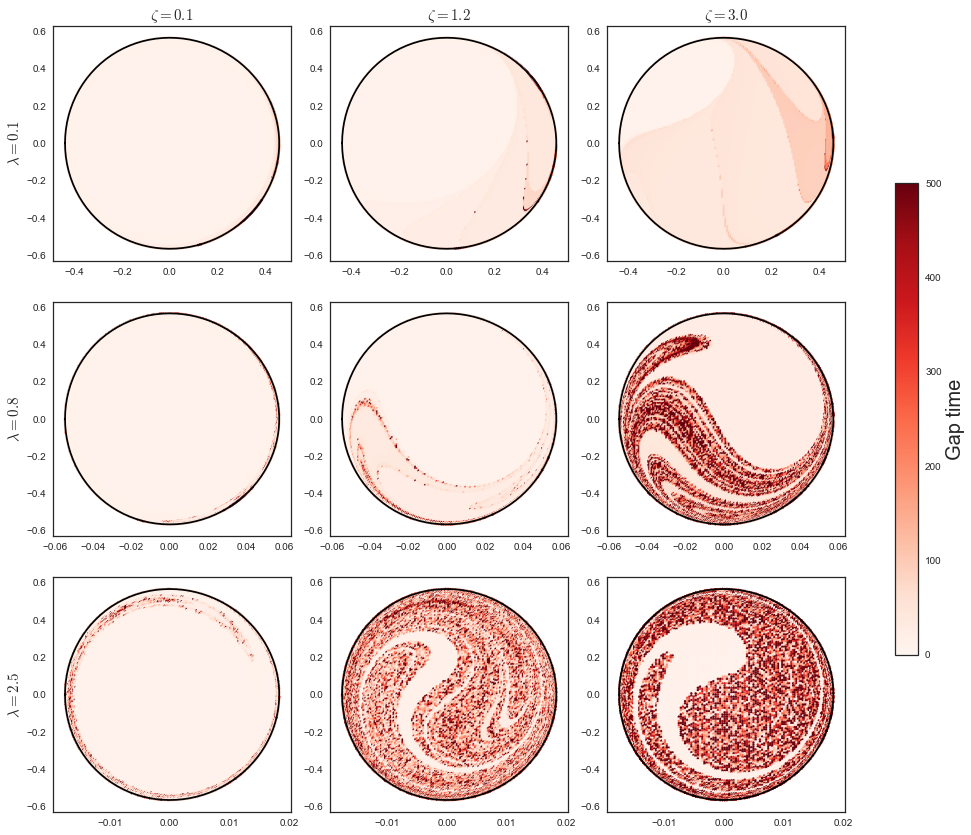

In [25]:
lambdas = [0.1, 0.8, 2.5]
zetas = [0.1, 1.2, 3.0]

axis_fs = 20
UPO_resolution = 100

cols = ['$\zeta = {}$'.format(zeta) for zeta in zetas]
rows = ['$\lambda = {}$'.format(lamb) for lamb in lambdas]

#----------------------------------------------------------------------------

fig, axs = plt.subplots(len(lambdas),len(zetas),figsize = (15,12))

for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=15)
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=15)
fig.tight_layout()


for lambda_num in range(len(lambdas)):
    for zeta_num in range(len(zetas)):
        
        lamb = lambdas[lambda_num]
        zeta = zetas[zeta_num]

        #             m_x, m_y, lamb, zeta, V,  y_w,     e_s, D_x
        parameters = [8,   8,   lamb,  zeta,  1,  1/2**.5, 1,   10]

        x_PO, t_period_PO = db.UPO(parameters, energy_level, UPO_timespan)
        times = np.linspace(0, t_period_PO, UPO_resolution)
        axs[lambda_num][zeta_num].plot(x_PO(times)[0,:], x_PO(times)[2,:], c = 'k')
        
        file_name = output_filename+'gap_time_data/gap_time_data_lambda'+str(lamb)+'zeta'+str(zeta)

        with open(file_name+'.npy', 'rb') as points_gap_times:
            points_gap_times = np.load(points_gap_times, allow_pickle = 1)

        sc = axs[lambda_num][zeta_num].scatter(points_gap_times[:,0],points_gap_times[:,2], \
                                               c=points_gap_times[:,4],\
                            cmap = cm.Reds, s=5, vmin = 0, vmax = max_runtime)

cbar = plt.colorbar(sc, ax = axs, shrink=0.6)
cbar.ax.set_ylabel('Gap time', fontsize=15)

fig.savefig(output_filename+'gap_time_DS_map')

### Gap time histogram

/Users/telegramsam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


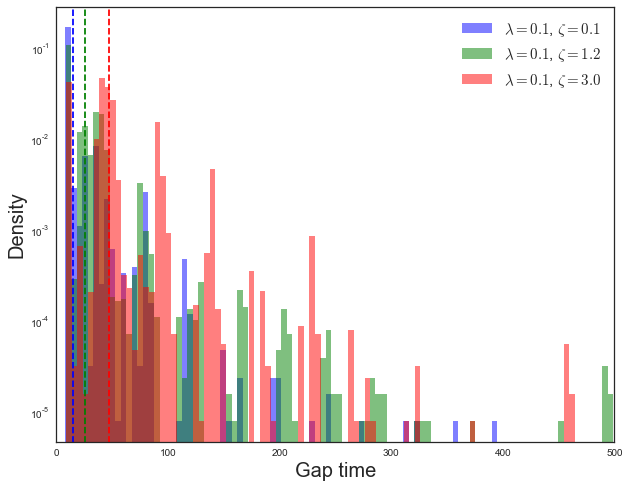

In [15]:
lamb_zeta_pairs = [[0.1, 0.1], [0.1, 1.2], [0.1, 3.0]]
n_hists = len(lamb_zeta_pairs)
axis_fs = 20

nbins = 200
ylim = 0.29

labels = ['$\lambda={}$'.format(pair[0])+', $\zeta={}$'.format(pair[1]) for pair in lamb_zeta_pairs]
colours = ['blue', 'green', 'red']
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(1, 1, 1)

gaptimes_hist = np.zeros((N_points, n_hists))
means = np.zeros(n_hists)

for i in range(n_hists):
    lamb, zeta = lamb_zeta_pairs[i]
    file_name = output_filename+'gap_time_data/gap_time_data_lambda'+str(lamb)+'zeta'+str(zeta)
    
    with open(file_name+'.npy', 'rb') as points_gap_times:
        points_gap_times = np.load(points_gap_times, allow_pickle = 1)
        
    ax.hist(points_gap_times[:,4], nbins, density=True, label=labels[i], \
            histtype='bar', alpha=0.5, color=colours[i], log = 1)
    
    means[i] = np.mean(points_gap_times[:,4])
    ax.plot(np.linspace(means[i], means[i], 2), np.linspace(0, ylim, 2), c=colours[i], \
            alpha = 1, linestyle = 'dashed')


ax.set_xlim(0, 500)
ax.set_ylim(0, ylim)
ax.set_xlabel('Gap time', fontsize=axis_fs)
ax.set_ylabel('Density', fontsize=axis_fs)
ax.legend(prop={'size': 15}, bbox_to_anchor=(1, 1), loc='upper right')


fig.savefig(output_filename+'gaptime_lambda_hist1.png')

/Users/telegramsam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


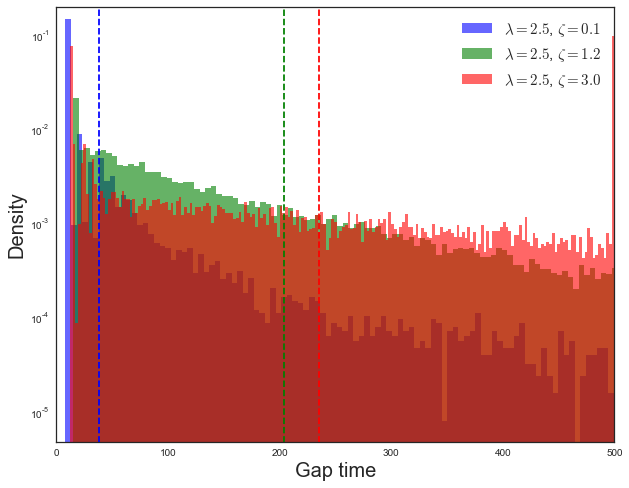

In [17]:
lamb_zeta_pairs = [[2.5, 0.1], [2.5, 1.2], [2.5, 3.0]]
n_hists = len(lamb_zeta_pairs)

nbins = 200
ylim = 0.2

labels = ['$\lambda={}$'.format(pair[0])+', $\zeta={}$'.format(pair[1]) for pair in lamb_zeta_pairs]
colours = ['blue', 'green', 'red']
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(1, 1, 1)

gaptimes_hist = np.zeros((N_points, n_hists))
means = np.zeros(n_hists)

for i in range(n_hists):
    lamb, zeta = lamb_zeta_pairs[i]
    file_name = output_filename+'gap_time_data/gap_time_data_lambda'+str(lamb)+'zeta'+str(zeta)
    
    with open(file_name+'.npy', 'rb') as points_gap_times:
        points_gap_times = np.load(points_gap_times, allow_pickle = 1)
        
    ax.hist(points_gap_times[:,4], nbins, density=True, label=labels[i], \
            histtype='bar', alpha=0.6, color=colours[i], log = 1)
    
    means[i] = np.mean(points_gap_times[:,4])
    ax.plot(np.linspace(means[i], means[i], 2), np.linspace(0, ylim, 2), c=colours[i], \
            alpha = 1, linestyle = 'dashed')


ax.set_xlim(0, 500)
ax.set_ylim(0, ylim)
ax.set_xlabel('Gap time', fontsize=axis_fs)
ax.set_ylabel('Density', fontsize=axis_fs)
ax.legend(prop={'size': 15}, bbox_to_anchor=(1, 1), loc='upper right')


fig.savefig(output_filename+'gaptime_lambda_hist2.png')

### Flux calculation

$$
\mathcal{F}_E = \oint_{\mathrm{UPO}} \mathbf{p} \cdot d\mathbf{q}
$$

In [ ]:
#             m_x, m_y, lamb, zeta, V,  y_w,     e_s, D_x
parameters = [8,   8,   1,  1.0,  1,  1/2**.5, 1,   10]
m_x, m_y, lamb, zeta, V,  y_w,     e_s, D_x = parameters
energy_level = 1.0002


flux_linearised = np.pi/(D_x*lamb**2)*(energy_level - e_s)
print('Linearised flux value = {}'.format(flux_linearised))

In [29]:
lamb_list = np.arange(0.05, 4, 0.05)
means = np.zeros((2,len(lamb_list)))

energy_level = 1.02

gap_times_from_flux = np.zeros(len(lamb_list))
gap_times_from_theoretical_flux = np.zeros(len(lamb_list))

for j in trange(len(lamb_list), smoothing = 0):
    lamb = lamb_list[j]
    #             m_x, m_y, lamb, zeta, V,  y_w,     e_s, D_x
    parameters = [8,   8,   lamb,  1.0,  1,  1/2**.5, 1,   10]
    gap_times_from_flux[j] = 1/db.flux_theoretical(energy_level, parameters)

with open(output_filename+'mean_gap_time_lambda.npy', 'rb') as means:
    means = np.load(means, allow_pickle = 1)

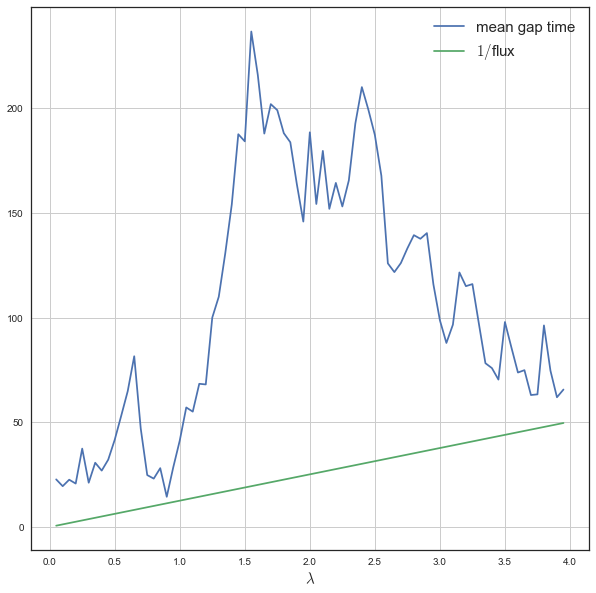

In [32]:
fig, ax = plt.subplots(1,1,figsize = (10,10))

ax.plot(lamb_list, means[1,:], label = 'mean gap time')
ax.plot(lamb_list, gap_times_from_flux, label = '$1/$flux')

ax.set_xlabel('$\lambda$', fontsize=15)
ax.grid()
ax.legend(fontsize = 15)
plt.show()
fig.savefig('mean_gap_time_lambda.png')

### Flux and gap time against energy, $\lambda = \zeta = 1$

In [5]:
energies = np.arange(1.02, 4, 0.02)
parameters = [8,   8,   3.0,  1.0,  1,  1/2**.5, 1,   10]
N = 20

N_points = np.size(db.forward_DS(N, parameters, 1.1, 100), 0)

UPO_timespan = 50
max_runtime = 500

with tqdm(total = (N_points-1)*len(energies), smoothing = 0.1, leave = 1) as pbar:
    for i in range(len(energies)):
        energy_level = energies[i]
        points = db.forward_DS(N, parameters, energy_level, 100)

        N_points = np.size(points, 0)
        points_gap_times = np.zeros((N_points, 5))

        points_gap_times[:,:4] = points

        for j in range(N_points):
            points_gap_times[j, 4] = db.gap_time(points[j,:], parameters, max_runtime)
            pbar.update(1)

        file_name = output_filename+'gap_time_data_energies/gap_time_data_E'+str(energy_level)
        np.save(file_name, points_gap_times)

  0%|          | 41/32333 [00:19<4:13:46,  2.12it/s] 


KeyboardInterrupt: 

In [6]:
def flux_numerical(energy_level, parameters, resolution = 100, UPO_timespan = 100):

    x_PO, t_period_PO = db.UPO(parameters, energy_level, UPO_timespan)
    times = np.linspace(0, t_period_PO, resolution)

    x_vals = x_PO(times)[0,:]
    px_vals = x_PO(times)[2,:]

    total = 0
    for i in range(1,resolution):
        p = px_vals[i]
        dq = x_vals[i] - x_vals[i-1]
        total += p * dq

    return total

In [8]:
energies = np.arange(1.02, 4, 0.02)
parameters = [8,   8,   0.1,  1.0,  1,  1/2**.5, 1,   10]

means = np.zeros((len(energies),))
flux_nums = np.zeros((len(energies),))

for i in trange(len(energies)):
    energy_level = energies[i]
    file_name = output_filename+'gap_time_data_energies/gap_time_data_E'+str(energy_level) + '.npy'
    
    with open(file_name, 'rb') as points_gap_times:
        points_gap_times = np.load(points_gap_times, allow_pickle = 1)
        
    means[i] = np.mean(points_gap_times[:,4])
    flux_nums[i] = flux_numerical(energy_level, parameters, resolution = 25)

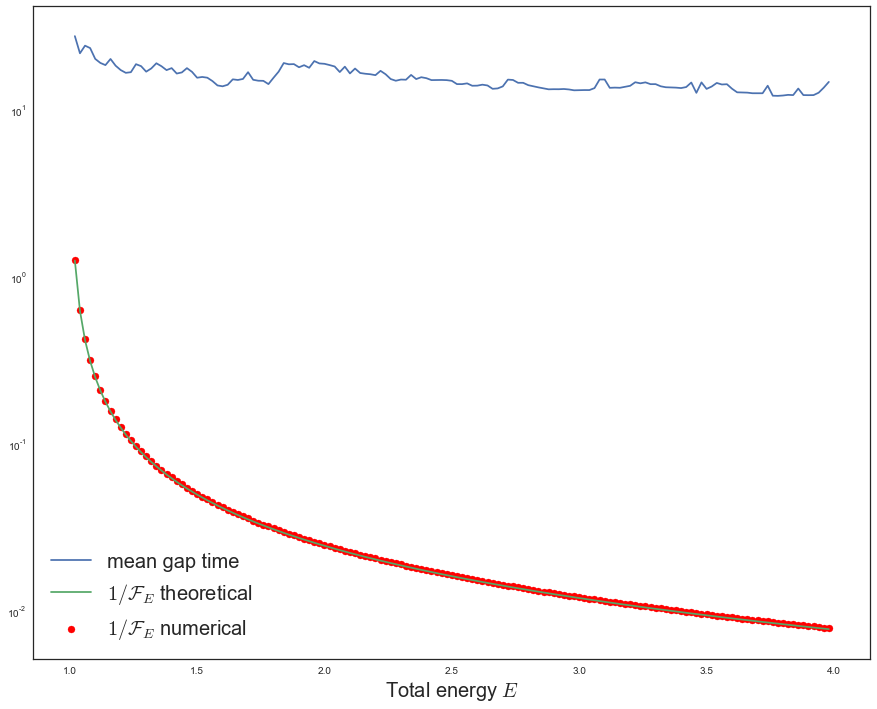

In [9]:
fig, ax = plt.subplots(1,1, figsize = (15, 12))
ax.plot(energies, means, label = 'mean gap time')
ax.plot(energies, 1/db.flux_theoretical(energies, parameters), label = '$1/\mathcal{F}_E$ theoretical' )
ax.scatter(energies, 1/flux_nums, label = '$1/\mathcal{F}_E$ numerical', marker = 'o', c = 'red')
ax.legend(fontsize = 20)
ax.set_xlabel('Total energy $E$', fontsize = 20)
ax.set_yscale('log')
fig.savefig(output_filename + 'gaptime_flux_energy_lamb0.1.png')


plt.show()